# 变分模态分解

变分模态分解（Variational Mode Decomposition，VMD）是一种信号处理技术，用于将**复杂的信号**分解成多个模态（或成分）。这种方法的目标是通过考虑信号在时频域的局部变化来提取信号中的各种模态成分。

VMD的主要思想是通过优化一个能量函数来找到信号的各个模态分量。这个能量函数包括两个部分：信号的平滑性和信号的稀疏性。通过迭代的方式，VMD能够逐步提取信号中的不同频率成分，形成一系列模态。

VMD的一些特点包括：

- 自适应性： VMD能够自适应地适应信号的频率变化，因此在处理**非平稳信号**时表现较好。
- 模态间正交性： VMD分解得到的各个模态是彼此正交的，这有助于更清晰地理解信号的结构。
- 参数少： VMD方法中通常只有一个需要调节的参数，使得其应用相对简单。

VMD的具体做法可以通过以下步骤来描述：

- 构建能量函数： 定义一个能量函数，该函数由信号的平滑性和稀疏性两个部分组成。这个能量函数通常采用拉格朗日乘子法，将平滑性和稀疏性的权重参数引入。

- 优化过程： 通过迭代优化能量函数，逐步提取信号的模态成分。优化的过程通常使用算法如梯度下降法等。

- 确定参数： 针对具体的应用场景，需要确定一些参数，比如模态数目、平滑性和稀疏性的权重等。这些参数的选择可能需要一些经验或者通过试验来确定。

- 迭代分解： 使用迭代方法，反复进行信号的分解，直到满足停止准则。在每次迭代中，通过调整参数来优化能量函数，提取信号的不同模态。

- 模态提取： 最终得到的模态表示信号在不同频率上的成分。这些模态是正交的，可以理解为信号在时频域上的局部特征。

In [20]:
import datetime as dt
import os
import warnings
from collections import UserDict
from tqdm import tqdm # 打印进度条

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 两种绘图接口
import plotly_express as px
import plotly.graph_objects as go

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签SimHei
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
%matplotlib inline

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)

In [3]:
from vmdpy import VMD # 加载VMD模块

# 加载数据集

16000
[122 133 149 151 165 151 160 159 155 151]


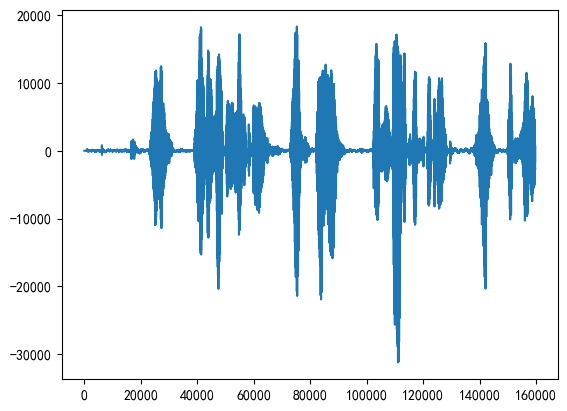

In [37]:
import scipy.io.wavfile as wav

# 读取音频，返回采样率和采样的数值
rate, all_samples = wav.read("../data/fft-test.wav")
print(rate)
print(all_samples[1000:1010])
# 运行结果

plt.plot(all_samples)
plt.show()

# 时间序列分解

## 选择合适模态数量

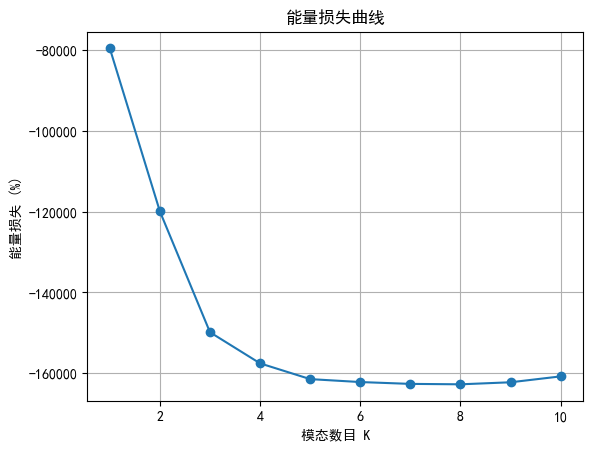

In [38]:
# 设置VMD参数
signal = all_samples
alpha = 500.0  # 数据保真性约束的平衡参数
tau = 0.  # 对偶上升法的时间步长
K_values = range(1, 11)  # 尝试不同的K值
DC = True  # 第一个模态放置在直流分量
init = 0  # 所有频率从0开始初始化
tol = 1e-6  # 收敛标准的容差

# 记录能量损失
energy_losses = []

# 进行VMD分解并计算能量损失
for K in K_values:
    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)
    
    # 计算每个模态的能量占总能量的比例
    energy = np.sum([np.sum(mode**2) for mode in u])
    total_energy = np.sum(signal**2)
    energy_loss = (1 - energy / total_energy) * 100
    energy_losses.append(energy_loss)

# 绘制能量损失曲线
plt.plot(K_values, energy_losses, marker='o')
plt.xlabel('模态数目 K')
plt.ylabel('能量损失 (%)')
plt.title('能量损失曲线')
plt.grid(True)
plt.show()

## 初始化VMD

In [39]:
K = np.where(np.array(energy_losses) == np.array(energy_losses).min())[0][0] # 选择能量损失最小的最为K值
# 构造参数字典
vmd_args = {
    "f": all_samples, # 要分解的时间域信号（1D数组）
    "alpha": 500., # 数据保真性约束的平衡参数
    "tau": 0., # 对偶上升法的时间步长（选择0表示噪声松弛）
    "K": K, # 要恢复的模态数
    "DC": True, # 如果为真，第一个模态放置在并保持在直流分量（0频率）
    "init": 0, # 初始化模态中心频率的方式。0：所有频率从0开始。1：所有频率均匀分布开始。2：所有频率以随机方式初始化。
    "tol": 1e-6, #  收敛标准的容差
}

#函数传参
u, u_hat, omega = VMD(**vmd_args)  # 设置模态数目
# u 是分解得到的模态
# u_hat 是各模态的频谱
# omega 是估计的模态中心频率

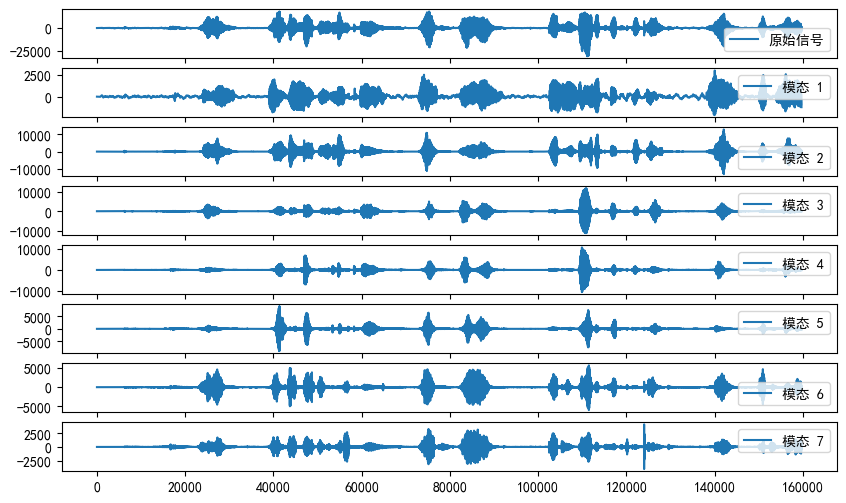

In [42]:
# 绘制原始信号及其分量
K = np.where(np.array(energy_losses) == np.array(energy_losses).min())[0][0] # 选择能量损失最小的最为K值
plt.figure(figsize=(10, 6))

plt.subplot(K + 1, 1, 1)
plt.plot(all_samples, label='原始信号')
plt.legend()

for i, mode in enumerate(u):
    plt.subplot(K + 1, 1, i + 2)
    plt.plot(mode, label=f'模态 {i + 1}')
    plt.legend()

plt.show()